<a href="https://colab.research.google.com/github/rediahmds/eco-sort/blob/main/train/train_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare dataset

In [ ]:
!pip install kagglehub

### Download

In [ ]:
import kagglehub

alistair_ds = kagglehub.dataset_download("alistairking/recyclable-and-household-waste-classification")
print("Path to dataset files:", alistair_ds)

mostafa_ds = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("Path to dataset files:", mostafa_ds)

joe_ds = kagglehub.dataset_download("joebeachcapital/realwaste")
print("Path to dataset files:", joe_ds)

Path to dataset files: /kaggle/input/recyclable-and-household-waste-classification
Path to dataset files: /kaggle/input/garbage-classification
Path to dataset files: /kaggle/input/realwaste


Show directory tree

In [ ]:
from pathlib import Path

def print_directory_tree(root: Path, prefix: str = ""):
    """
    Mencetak struktur direktori dengan tampilan seperti pohon.
    Hanya menampilkan folder (tanpa file).
    """
    subdirs = sorted([p for p in root.iterdir() if p.is_dir()])
    for i, subdir in enumerate(subdirs):
        connector = "└── " if i == len(subdirs) - 1 else "├── "
        print(f"{prefix}{connector}{subdir.name}")
        extension = "    " if i == len(subdirs) - 1 else "│   "
        print_directory_tree(subdir, prefix + extension)

# Path ke folder utama
alistair_path = Path(alistair_ds) / "images" / "images"
mostafa_path = Path(mostafa_ds) / "garbage_classification"
joe_path = Path(joe_ds) / "realwaste-main" / "RealWaste"

# Cetak pohon direktori
print(alistair_path.name)
print_directory_tree(alistair_path)

print(mostafa_path.name)
print_directory_tree(mostafa_path)

print(joe_path.name)
print_directory_tree(joe_path)


images
├── aerosol_cans
│   ├── default
│   └── real_world
├── aluminum_food_cans
│   ├── default
│   └── real_world
├── aluminum_soda_cans
│   ├── default
│   └── real_world
├── cardboard_boxes
│   ├── default
│   └── real_world
├── cardboard_packaging
│   ├── default
│   └── real_world
├── clothing
│   ├── default
│   └── real_world
├── coffee_grounds
│   ├── default
│   └── real_world
├── disposable_plastic_cutlery
│   ├── default
│   └── real_world
├── eggshells
│   ├── default
│   └── real_world
├── food_waste
│   ├── default
│   └── real_world
├── glass_beverage_bottles
│   ├── default
│   └── real_world
├── glass_cosmetic_containers
│   ├── default
│   └── real_world
├── glass_food_jars
│   ├── default
│   └── real_world
├── magazines
│   ├── default
│   └── real_world
├── newspaper
│   ├── default
│   └── real_world
├── office_paper
│   ├── default
│   └── real_world
├── paper_cups
│   ├── default
│   └── real_world
├── plastic_cup_lids
│   ├── default
│   └── real_world
├── pl

### Copy Dataset

In [ ]:
from pathlib import Path
import shutil
import random

def copy_n_files(src_dir, dst_dir, n, randomize=False):
    src_path = Path(src_dir)
    dst_path = Path(dst_dir)

    # Buat folder tujuan jika belum ada
    dst_path.mkdir(parents=True, exist_ok=True)

    # Ambil semua file dari direktori sumber
    all_files = [f for f in src_path.iterdir() if f.is_file()]

    # Pastikan n tidak lebih besar dari jumlah file
    n = min(n, len(all_files))

    # Tentukan file mana yang akan disalin
    if randomize:
        files_to_copy = random.sample(all_files, n)
    else:
        files_to_copy = sorted(all_files)[:n]

    # Copy file satu per satu
    for file in files_to_copy:
        shutil.copy(file, dst_path)
        print(f"Copied: {file.name}")

    print(f"\nTotal {n} files copied from '{src_dir}' to '{dst_dir}' (random: {randomize}).")


#### Customize Alistair Dataset

In [ ]:
from pathlib import Path
import shutil
from tqdm import tqdm

source_root = alistair_path
target_root = Path("dataset/train")
target_root.mkdir(parents=True, exist_ok=True)

class_map = {
    "food_waste": "organic",
    "eggshells": "organic",
    "coffee_grounds": "organic",
    "tea_bags": "organic",
    "plastic_soda_bottles": "plastic",
    "plastic_trash_bags": "plastic",
    "plastic_food_containers": "plastic",
    "plastic_shopping_bags": "plastic",
    "plastic_straws": "plastic",
    "plastic_water_bottles": "plastic",
    "plastic_detergent_bottles": "plastic",
    "plastic_cup_lids": "plastic",
    "glass_food_jars": "glass",
    "glass_beverage_bottles": "glass",
    "glass_cosmetic_containers": "glass",
    "aluminum_soda_cans": "metal",
    "aluminum_food_cans": "metal",
    "steel_food_cans": "metal",
    "aerosol_cans": "metal",
    "cardboard_boxes": "paper",
    "cardboard_packaging": "paper",
    "magazines": "paper",
    "newspaper": "paper",
    "office_paper": "paper",
    "paper_cups": "paper",
    "styrofoam_cups": "styrofoam",
    "styrofoam_food_containers": "styrofoam",
    "clothing": "textiles",
    "shoes": "textiles"
}

print("🚀 Memulai pengelompokan dataset dengan penamaan ulang...\n")

for class_name, parent_class in class_map.items():
    for subset in ["default", "real_world"]:
        class_dir = source_root / class_name / subset
        if class_dir.exists():
            img_list = list(class_dir.glob("*.*"))
            print(f"📁 Menyalin {len(img_list)} gambar dari '{class_name}/{subset}' ke '{parent_class}'")
            for i, img in enumerate(tqdm(img_list, desc=f"{class_name}/{subset}", leave=False)):
                dest_dir = target_root / parent_class
                dest_dir.mkdir(parents=True, exist_ok=True)

                # Penamaan ulang
                ext = img.suffix
                new_name = f"{subset}_{class_name}_{i:04d}{ext}"
                shutil.copy(img, dest_dir / new_name)

print("\n✅ Pengelompokan selesai tanpa konflik penamaan.")
print("📂 Dataset tersimpan di:", target_root.resolve())


🚀 Memulai pengelompokan dataset dengan penamaan ulang...

📁 Menyalin 250 gambar dari 'food_waste/default' ke 'organic'


📁 Menyalin 250 gambar dari 'food_waste/real_world' ke 'organic'


📁 Menyalin 250 gambar dari 'eggshells/default' ke 'organic'


📁 Menyalin 250 gambar dari 'eggshells/real_world' ke 'organic'


📁 Menyalin 250 gambar dari 'coffee_grounds/default' ke 'organic'


📁 Menyalin 250 gambar dari 'coffee_grounds/real_world' ke 'organic'


📁 Menyalin 250 gambar dari 'tea_bags/default' ke 'organic'


📁 Menyalin 250 gambar dari 'tea_bags/real_world' ke 'organic'


📁 Menyalin 250 gambar dari 'plastic_soda_bottles/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_soda_bottles/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_trash_bags/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_trash_bags/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_food_containers/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_food_containers/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_shopping_bags/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_shopping_bags/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_straws/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_straws/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_water_bottles/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_water_bottles/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_detergent_bottles/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_detergent_bottles/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_cup_lids/default' ke 'plastic'


📁 Menyalin 250 gambar dari 'plastic_cup_lids/real_world' ke 'plastic'


📁 Menyalin 250 gambar dari 'glass_food_jars/default' ke 'glass'


📁 Menyalin 250 gambar dari 'glass_food_jars/real_world' ke 'glass'


📁 Menyalin 250 gambar dari 'glass_beverage_bottles/default' ke 'glass'


📁 Menyalin 250 gambar dari 'glass_beverage_bottles/real_world' ke 'glass'


📁 Menyalin 250 gambar dari 'glass_cosmetic_containers/default' ke 'glass'


📁 Menyalin 250 gambar dari 'glass_cosmetic_containers/real_world' ke 'glass'


📁 Menyalin 250 gambar dari 'aluminum_soda_cans/default' ke 'metal'


📁 Menyalin 250 gambar dari 'aluminum_soda_cans/real_world' ke 'metal'


📁 Menyalin 250 gambar dari 'aluminum_food_cans/default' ke 'metal'


📁 Menyalin 250 gambar dari 'aluminum_food_cans/real_world' ke 'metal'


📁 Menyalin 250 gambar dari 'steel_food_cans/default' ke 'metal'


📁 Menyalin 250 gambar dari 'steel_food_cans/real_world' ke 'metal'


📁 Menyalin 250 gambar dari 'aerosol_cans/default' ke 'metal'


📁 Menyalin 250 gambar dari 'aerosol_cans/real_world' ke 'metal'


📁 Menyalin 250 gambar dari 'cardboard_boxes/default' ke 'paper'


📁 Menyalin 250 gambar dari 'cardboard_boxes/real_world' ke 'paper'


📁 Menyalin 250 gambar dari 'cardboard_packaging/default' ke 'paper'


📁 Menyalin 250 gambar dari 'cardboard_packaging/real_world' ke 'paper'


📁 Menyalin 250 gambar dari 'magazines/default' ke 'paper'


📁 Menyalin 250 gambar dari 'magazines/real_world' ke 'paper'


📁 Menyalin 250 gambar dari 'newspaper/default' ke 'paper'


📁 Menyalin 250 gambar dari 'newspaper/real_world' ke 'paper'


📁 Menyalin 250 gambar dari 'office_paper/default' ke 'paper'


📁 Menyalin 250 gambar dari 'office_paper/real_world' ke 'paper'


📁 Menyalin 250 gambar dari 'paper_cups/default' ke 'paper'


📁 Menyalin 250 gambar dari 'paper_cups/real_world' ke 'paper'


📁 Menyalin 250 gambar dari 'styrofoam_cups/default' ke 'styrofoam'


📁 Menyalin 250 gambar dari 'styrofoam_cups/real_world' ke 'styrofoam'


📁 Menyalin 250 gambar dari 'styrofoam_food_containers/default' ke 'styrofoam'


📁 Menyalin 250 gambar dari 'styrofoam_food_containers/real_world' ke 'styrofoam'


📁 Menyalin 250 gambar dari 'clothing/default' ke 'textiles'


📁 Menyalin 250 gambar dari 'clothing/real_world' ke 'textiles'


📁 Menyalin 250 gambar dari 'shoes/default' ke 'textiles'


📁 Menyalin 250 gambar dari 'shoes/real_world' ke 'textiles'



✅ Pengelompokan selesai tanpa konflik penamaan.
📂 Dataset tersimpan di: /content/dataset/train


In [ ]:
# Uncomment all for first run

copy_n_files(f"{mostafa_ds}/garbage_classification/paper", "dataset/train/paper", 500, randomize=True)
copy_n_files(f"{mostafa_ds}/garbage_classification/cardboard", "dataset/train/paper", 500, randomize=True)

copy_n_files(f"{mostafa_ds}/garbage_classification/white-glass", "dataset/train/glass", 600, randomize=True)
copy_n_files(f"{mostafa_ds}/garbage_classification/brown-glass", "dataset/train/glass", 600, randomize=True)
copy_n_files(f"{mostafa_ds}/garbage_classification/green-glass", "dataset/train/glass", 600, randomize=True)

copy_n_files(f"{mostafa_ds}/garbage_classification/clothes", "dataset/train/textiles", 1500, randomize=True)
copy_n_files(f"{mostafa_ds}/garbage_classification/shoes", "dataset/train/textiles", 1500, randomize=True)

copy_n_files(f"{mostafa_ds}/garbage_classification/metal", "dataset/train/metal", 750, randomize=True)
copy_n_files(f"{joe_ds}/realwaste-main/RealWaste/Metal", "dataset/train/metal", 750, randomize=True)


Streaming output truncated to the last 5000 lines.
Copied: green-glass108.jpg
Copied: green-glass531.jpg
Copied: green-glass324.jpg
Copied: green-glass205.jpg
Copied: green-glass333.jpg
Copied: green-glass556.jpg
Copied: green-glass152.jpg
Copied: green-glass547.jpg
Copied: green-glass412.jpg
Copied: green-glass326.jpg
Copied: green-glass573.jpg
Copied: green-glass628.jpg
Copied: green-glass201.jpg
Copied: green-glass564.jpg
Copied: green-glass321.jpg
Copied: green-glass248.jpg
Copied: green-glass452.jpg
Copied: green-glass368.jpg
Copied: green-glass623.jpg
Copied: green-glass339.jpg
Copied: green-glass535.jpg
Copied: green-glass59.jpg
Copied: green-glass153.jpg
Copied: green-glass247.jpg
Copied: green-glass360.jpg
Copied: green-glass89.jpg
Copied: green-glass394.jpg
Copied: green-glass392.jpg
Copied: green-glass577.jpg
Copied: green-glass46.jpg
Copied: green-glass348.jpg
Copied: green-glass376.jpg
Copied: green-glass468.jpg
Copied: green-glass609.jpg
Copied: green-glass107.jpg
Copied:

#### TODO: Check for duplicates

### Create Validation Dataset

This dataset will be created by moving some files from training dataset.

In [ ]:
def move_validation_split_custom(train_dir, val_dir, per_class_counts: dict, random_select=True):
    train_dir = Path(train_dir)
    val_dir = Path(val_dir)
    val_dir.mkdir(parents=True, exist_ok=True)

    for class_name, n in per_class_counts.items():
        class_dir = train_dir / class_name
        if not class_dir.exists():
            print(f"⚠️ Folder tidak ditemukan: {class_dir}")
            continue

        images = sorted([p for p in class_dir.glob("*.*") if p.suffix.lower() in {'.jpg', '.jpeg', '.png'}])
        selected = random.sample(images, min(n, len(images))) if random_select else images[:n]
        val_class_dir = val_dir / class_name
        val_class_dir.mkdir(parents=True, exist_ok=True)

        print(f"📁 {class_name}: Memindahkan {len(selected)} file...")
        for img in tqdm(selected, desc=f"  Pindah {class_name}", leave=False):
            shutil.move(str(img), str(val_class_dir / img.name))

    print("\n✅ Selesai membuat validasi set proporsional.")


In [ ]:
# 15% validasi per kelas
per_class_counts = {
    "glass": 495,
    "metal": 525,
    "organic": 300,
    "paper": 600,
    "plastic": 600,
    "styrofoam": 150,
    "textiles": 600
}

move_validation_split_custom("dataset/train", "dataset/test", per_class_counts, random_select=True)

📁 glass: Memindahkan 495 file...


📁 metal: Memindahkan 525 file...


📁 organic: Memindahkan 300 file...


📁 paper: Memindahkan 600 file...


📁 plastic: Memindahkan 600 file...


📁 styrofoam: Memindahkan 150 file...


📁 textiles: Memindahkan 600 file...



✅ Selesai membuat validasi set proporsional.


### Data Distribution checking

In [ ]:
from collections import Counter
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder("dataset/train")
label_counts = Counter([label for _, label in train_dataset])
print("Label mapping:", train_dataset.class_to_idx)
print("Distribusi kelas:", label_counts)

test_dataset = ImageFolder("dataset/test")
label_counts = Counter([label for _, label in test_dataset])
print("Distribusi kelas:", label_counts)


Label mapping: {'glass': 0, 'metal': 1, 'organic': 2, 'paper': 3, 'plastic': 4, 'styrofoam': 5, 'textiles': 6}
Distribusi kelas: Counter({3: 3400, 4: 3400, 6: 3400, 1: 2975, 0: 2805, 2: 1700, 5: 850})
Distribusi kelas: Counter({3: 600, 4: 600, 6: 600, 1: 525, 0: 495, 2: 300, 5: 150})


### Connect to Google Drive (Optional)

This functionality allows to save the trained models to current Google account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Training and Evaluation

#### Setup ClearML

Go ahead and sign-up/sign-in to [AI Infrastructure Platform | Maximize AI Performance & Scalability | ClearML](https://clear.ml/)

After that, go to Settings -> Workspace -> Create new credentials

The new credentials will be created and shows two options:

Local Python (Recommended)
Jupyter Notebook
Both actually are the same things, it only differs on how to use the new credentials.

This time, use the clearml CLI app to consume the credentials, when prompted, paste it.

In [ ]:
!pip install clearml

In [ ]:
!clearml-init

In [ ]:
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
#@title <b>Time Out Preventer (Advanced) </b></strong>
%%capture
AUTO_RECONNECT = True #@param {type:"boolean"}
#@markdown **Run this code to prevent Google Colab from Timeout**
from os import makedirs
makedirs("/root/.config/rclone", exist_ok = True)
if AUTO_RECONNECT:
  import IPython
  from google.colab import output

  display(IPython.display.Javascript('''
  function ClickConnect(){
    btn = document.querySelector("colab-connect-button")
    if (btn != null){
      console.log("Click colab-connect-button");
      btn.click()
      }

    btn = document.getElementById('ok')
    if (btn != null){
      console.log("Click reconnect");
      btn.click()
      }
    }

  setInterval(ClickConnect,60000)
  '''))

### Training Options (Choose one of these)

#### (1) Training with early stopping - Recommended

Label mapping: {'glass': 0, 'metal': 1, 'organic': 2, 'paper': 3, 'plastic': 4, 'styrofoam': 5, 'textiles': 6}
Train distribusi: Counter({3: 3400, 4: 3400, 6: 3400, 1: 2975, 0: 2805, 2: 1700, 5: 850})
Val distribusi: Counter({3: 600, 4: 600, 6: 600, 1: 525, 0: 495, 2: 300, 5: 150})
Epoch 1/32 - Train Acc: 0.6709 - Val Acc: 0.7483
🌟 BEST model disimpan.
Epoch 2/32 - Train Acc: 0.7579 - Val Acc: 0.8009
🌟 BEST model disimpan.
Epoch 3/32 - Train Acc: 0.7971 - Val Acc: 0.8187
🌟 BEST model disimpan.
Epoch 4/32 - Train Acc: 0.8305 - Val Acc: 0.7982
📦 Model disimpan.
Epoch 5/32 - Train Acc: 0.8505 - Val Acc: 0.8364
🌟 BEST model disimpan.
Epoch 6/32 - Train Acc: 0.8715 - Val Acc: 0.8330
📦 Model disimpan.
Epoch 7/32 - Train Acc: 0.8847 - Val Acc: 0.8315
📦 Model disimpan.
Epoch 8/32 - Train Acc: 0.8958 - Val Acc: 0.8502
🌟 BEST model disimpan.
Epoch 9/32 - Train Acc: 0.9135 - Val Acc: 0.8529
🌟 BEST model disimpan.
Epoch 10/32 - Train Acc: 0.9205 - Val Acc: 0.8609
🌟 BEST model disimpan.
Epoch 11/32

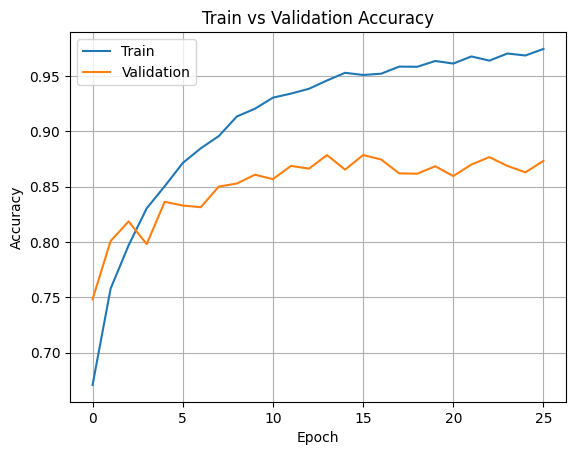

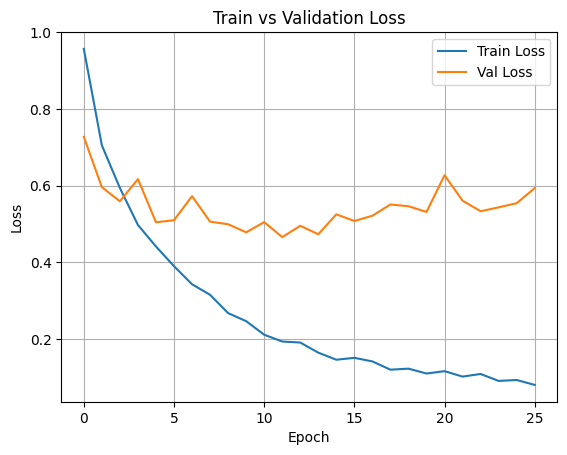

=== Classification Report ===
              precision    recall  f1-score   support

       glass       0.82      0.92      0.87       495
       metal       0.88      0.85      0.87       525
     organic       0.85      0.86      0.86       300
       paper       0.85      0.88      0.86       600
     plastic       0.87      0.87      0.87       600
   styrofoam       0.90      0.82      0.86       150
    textiles       0.95      0.88      0.91       600

    accuracy                           0.87      3270
   macro avg       0.88      0.87      0.87      3270
weighted avg       0.88      0.87      0.87      3270



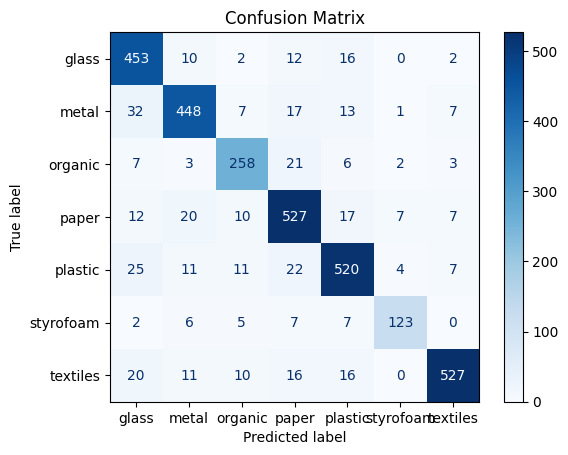

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# 🔁 Transformasi
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


# 📁 Load dataset
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
val_dataset = datasets.ImageFolder("dataset/test", transform=transform)
class_names = train_dataset.classes
print("Label mapping:", train_dataset.class_to_idx)
print("Train distribusi:", Counter([label for _, label in train_dataset]))
print("Val distribusi:", Counter([label for _, label in val_dataset]))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ⚙️ Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Inbalanced dataset
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

# 🎯 Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# 🔁 Training loop
epochs = 32
patience = 12
train_accs, val_accs = [], []
train_losses, val_losses = [], []
best_val_acc = 0
early_stop_counter = 0

# Model Storage
best_model_path = "/content/drive/MyDrive/Cool Lee Yeah/8th Semester/Skripsi/AI Models/best_model.pt"
latest_model_path = "/content/drive/MyDrive/Cool Lee Yeah/8th Semester/Skripsi/AI Models/model_latest.pt"

for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

    train_acc = correct / total
    train_accs.append(train_acc.item())
    train_losses.append(train_loss / len(train_loader))

    # 🔍 Validasi
    model.eval()
    val_loss = 0
    correct, total = 0, 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_acc = correct / total
    val_accs.append(val_acc.item())
    val_losses.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f} - Val Acc: {val_acc:.4f}")

    # 💾 Simpan model terbaik
    if val_acc >= best_val_acc:
        best_val_acc = val_acc
        early_stop_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("🌟 BEST model disimpan.")
    else:
        torch.save(model.state_dict(), latest_model_path)
        print("📦 Model disimpan.")

        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

    print("\n")

# 📊 Grafik Accuracy
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 📉 Grafik Loss
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 📑 Classification Report
print("=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# 🔷 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


#### (2) Training without early stopping

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import time

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Dataset
train_dataset = datasets.ImageFolder("dataset/train", transform=transform)
class_names = train_dataset.classes
print("Label mapping:", train_dataset.class_to_idx)
print("Distribusi:", Counter([label for _, label in train_dataset]))

val_dataset = datasets.ImageFolder("dataset/test", transform=transform)
print("Label mapping:", val_dataset.class_to_idx)
print("Distribusi:", Counter([label for _, label in val_dataset]))

# Split
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model = model.to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
epochs = 6
train_accs, val_accs = [], []
best_val_acc = 0

for epoch in range(epochs):
    model.train()
    correct, total, loss_total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_total += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels)
        total += labels.size(0)

    train_acc = correct / total
    train_accs.append(train_acc.item())
    print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc:.4f}")

    # Validasi
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

    val_acc = correct / total
    val_accs.append(val_acc.item())
    print(f"            → Val Acc: {val_acc:.4f}")

# Simpan
torch.save(model.state_dict(), "model_cnn.pt")
print("✅ Model disimpan.")

Label mapping: {'non_organic': 0, 'organic': 1}
Distribusi: Counter({0: 1000, 1: 1000})
Label mapping: {'non_organic': 0, 'organic': 1}
Distribusi: Counter({0: 200, 1: 200})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/6 - Train Acc: 0.7750
            → Val Acc: 0.8850
Epoch 2/6 - Train Acc: 0.8655
            → Val Acc: 0.8750
Epoch 3/6 - Train Acc: 0.8725
            → Val Acc: 0.8950
Epoch 4/6 - Train Acc: 0.8720
            → Val Acc: 0.8600
Epoch 5/6 - Train Acc: 0.8730
            → Val Acc: 0.8975
Epoch 6/6 - Train Acc: 0.8915
            → Val Acc: 0.9175
✅ Model disimpan.


### Evaluation


=== Classification Report ===
              precision    recall  f1-score   support

 non_organic       0.94      0.89      0.92       200
     organic       0.90      0.94      0.92       200

    accuracy                           0.92       400
   macro avg       0.92      0.92      0.92       400
weighted avg       0.92      0.92      0.92       400



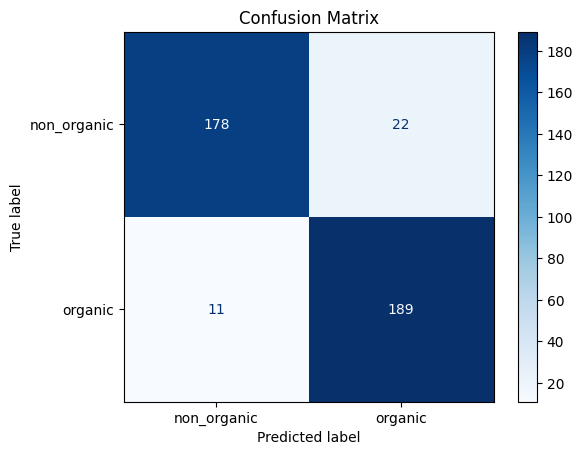

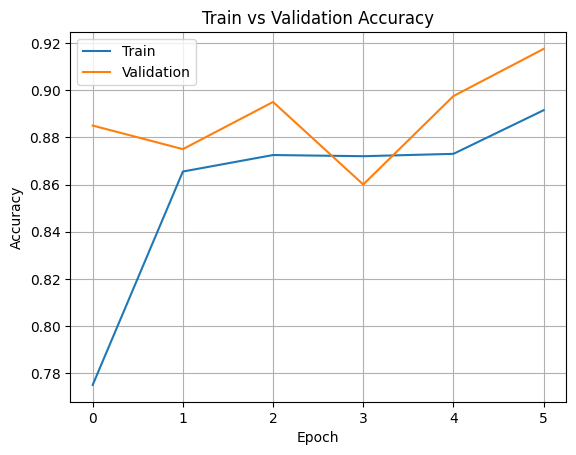

In [ ]:
# 📊 Evaluasi dengan laporan & Confusion Matrix
model.eval()
y_true, y_pred = [], []

for images, labels in val_loader:
    images = images.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds.cpu().numpy())

print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Plot akurasi training & val
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()